In [8]:
%pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 1.6 MB/s eta 0:00:00


# **For per hour comparison**

In [10]:
# code with serial and parallel implementation

import numpy as np
import pandas as pd
import multiprocessing as mp
from multiprocessing import cpu_count
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import time

# GA hyperparameters
POPULATION_SIZE = 100
N_GENERATIONS = 50
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.1
N_CORES = cpu_count()

# Load datasets
source_gen = pd.read_csv("source_generation.csv")
node_demand = pd.read_csv("node_demand.csv")
transmission_df = pd.read_csv("transmission_network.csv")
costs = pd.read_csv("cost_data.csv")

sources = costs['Source'].tolist()
NUM_SOURCES = len(sources)
NUM_NODES = node_demand.shape[1] - 1  # exclude "hour" column
HOURS = 24

# Helper: get per-hour data bundled
hourly_data_list = []
for h in range(HOURS):
    hourly_data_list.append({
        'generation': source_gen.iloc[h],
        'demand': node_demand.iloc[h],
        'transmission': transmission_df.copy(),
        'cost': costs.copy()
    })



# GA setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

def init_individual():
    generation = hourly_data_list[0]['generation']
    demand = hourly_data_list[0]['demand']
    individual_array = np.zeros((NUM_SOURCES, NUM_NODES))
    for i, src in enumerate(sources):
        src_cap = generation[src]
        for j in range(NUM_NODES):
            node_demand_val = demand[f'Node_{j+1}']
            max_alloc = min(src_cap, node_demand_val)
            individual_array[i, j] = np.random.uniform(0, max_alloc)
    return creator.Individual([individual_array])

toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)

def mutate_individual(individual):
    chromo = individual[0]
    noise = np.random.normal(0, 0.05 * max(chromo.max(), 1e-6), size=chromo.shape)
    chromo += noise
    np.clip(chromo, 0, None, out=chromo)
    return (individual,)

toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)

def calculate_fitness(chromosome, hourly_data):
    chromo_array = chromosome[0]
    n_sources, n_nodes = chromo_array.shape
    generation = hourly_data['generation']
    demand = hourly_data['demand']
    transmission = hourly_data['transmission']
    cost_data = hourly_data['cost']

    BASE_SCORE = 15000
    fitness = BASE_SCORE

    demands = np.array([demand[f'Node_{i+1}'] for i in range(n_nodes)])
    source_capacities = np.array([generation[src] for src in sources])
    source_costs = cost_data['Generation_Cost_per_kWh'].values
    trans_costs = cost_data['Transmission_Cost_per_kWh_km'].values

    dist_matrix = transmission.groupby(['From', 'To'])['Distance_km'].first().unstack().reindex(
        index=sources, columns=[f'Node_{i+1}' for i in range(n_nodes)]).fillna(0).values

    loss_rates = np.zeros((n_sources, n_nodes))
    for i, src in enumerate(sources):
        for j in range(n_nodes):
            node = f'Node_{j+1}'
            row = transmission[(transmission['From'] == src) & (transmission['To'] == node)]
            if not row.empty:
                loss_rates[i, j] = row['Loss_Percent'].values[0] / 100

    generation_cost = np.sum(chromo_array * source_costs[:, None])
    transmission_cost = np.sum(chromo_array * trans_costs[:, None] * dist_matrix)
    total_cost = generation_cost + transmission_cost
    fitness -= total_cost

    total_loss = np.sum(chromo_array * loss_rates)
    fitness -= total_loss * 10  # Penalty weight

    supplied_from_sources = np.sum(chromo_array, axis=1)
    source_viol = np.maximum(0, supplied_from_sources - source_capacities)
    fitness -= np.sum(source_viol) * 100  # Penalty for source capacity violation

    supplied_to_nodes = np.sum(chromo_array, axis=0)
    node_viol = np.maximum(0, supplied_to_nodes - demands)
    fitness -= np.sum(node_viol) * 100  # Penalty for over-supply

    neg_viol = np.sum(np.maximum(0, -chromo_array))
    fitness -= neg_viol * 1000  # Penalty for negative allocations

    unmet = np.maximum(0, demands - supplied_to_nodes)
    fitness -= np.sum(unmet) * 200  # Penalty for unmet demand

    return (fitness,)

def hour_fitness_wrapper(ind, hour_index):
    return calculate_fitness(ind, hourly_data_list[hour_index])

toolbox.register("evaluate", calculate_fitness)

def evaluate_population_parallel(pop, hour_index):
    with mp.Pool(N_CORES) as pool:
        results = pool.starmap(hour_fitness_wrapper, [(ind, hour_index) for ind in pop])
    return results

def evaluate_population_serial(pop, hour_index):
    results = []
    for ind in pop:
        results.append(hour_fitness_wrapper(ind, hour_index))
    return results

def run_hour_ga(hour_index, parallel=True):
    def init_individual_hour():
        generation = hourly_data_list[hour_index]['generation']
        demand = hourly_data_list[hour_index]['demand']
        individual_array = np.zeros((NUM_SOURCES, NUM_NODES))
        for i, src in enumerate(sources):
            src_cap = generation[src]
            for j in range(NUM_NODES):
                node_demand_val = demand[f'Node_{j+1}']
                max_alloc = min(src_cap, node_demand_val)
                individual_array[i, j] = np.random.uniform(0, max_alloc)
        return creator.Individual([individual_array])

    toolbox.register("individual", init_individual_hour)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    pop = toolbox.population(n=POPULATION_SIZE)

    if parallel:
        fitnesses = evaluate_population_parallel(pop, hour_index)
    else:
        fitnesses = evaluate_population_serial(pop, hour_index)

    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    log = tools.Logbook()
    stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    for gen in range(N_GENERATIONS):
        offspring = toolbox.select(pop, len(pop))
        offspring = algorithms.varAnd(offspring, toolbox, cxpb=CROSSOVER_RATE, mutpb=MUTATION_RATE)
        for ind in offspring:
            np.clip(ind[0], 0, None, out=ind[0])
        invalid = [ind for ind in offspring if not ind.fitness.valid]

        if parallel:
            fitnesses = evaluate_population_parallel(invalid, hour_index)
        else:
            fitnesses = evaluate_population_serial(invalid, hour_index)

        for ind, fit in zip(invalid, fitnesses):
            ind.fitness.values = fit
        pop[:] = offspring

        record = stats.compile(pop)
        log.record(gen=gen, **record)

    best = tools.selBest(pop, 1)[0]
    return best, log

def compare_serial_parallel(hour=0):
    print(f"Comparing serial vs parallel GA runs for Hour {hour}...\n")

    # Run serial GA and measure time
    start_serial = time.time()
    best_serial, log_serial = run_hour_ga(hour, parallel=False)
    end_serial = time.time()
    serial_time = end_serial - start_serial
    print(f"Serial GA took {serial_time:.2f} seconds.")

    # Run parallel GA and measure time
    start_parallel = time.time()
    best_parallel, log_parallel = run_hour_ga(hour, parallel=True)
    end_parallel = time.time()
    parallel_time = end_parallel - start_parallel
    print(f"Parallel GA took {parallel_time:.2f} seconds.")

    # Fitness comparison
    fitness_serial = best_serial.fitness.values[0]
    fitness_parallel = best_parallel.fitness.values[0]
    fitness_diff = abs(fitness_serial - fitness_parallel)
    print(f"\nBest fitness Serial: {fitness_serial:.4f}")
    print(f"Best fitness Parallel: {fitness_parallel:.4f}")
    print(f"Absolute fitness difference: {fitness_diff:.4f}")

    # Allocation matrix comparison
    alloc_serial = best_serial[0]
    alloc_parallel = best_parallel[0]
    alloc_diff = np.abs(alloc_serial - alloc_parallel)
    max_alloc_diff = alloc_diff.max()
    mean_alloc_diff = alloc_diff.mean()
    print(f"\nAllocation matrix max absolute difference: {max_alloc_diff:.4f}")
    print(f"Allocation matrix mean absolute difference: {mean_alloc_diff:.4f}")

    # Plot convergence side-by-side
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(log_serial.select("max"), label="Max Fitness")
    plt.plot(log_serial.select("avg"), label="Avg Fitness")
    plt.title(f"Serial GA Convergence (Hour {hour})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(log_parallel.select("max"), label="Max Fitness")
    plt.plot(log_parallel.select("avg"), label="Avg Fitness")
    plt.title(f"Parallel GA Convergence (Hour {hour})")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print best allocations side by side for visual check
    df_serial = pd.DataFrame(alloc_serial, index=sources,
                             columns=[f"Node_{i+1}" for i in range(NUM_NODES)])
    df_parallel = pd.DataFrame(alloc_parallel, index=sources,
                               columns=[f"Node_{i+1}" for i in range(NUM_NODES)])

    print("\nBest Allocation Matrix - Serial GA:")
    print(df_serial.round(2))

    print("\nBest Allocation Matrix - Parallel GA:")
    print(df_parallel.round(2))

    print("\nSummary:")
    print(f"- Parallel GA was {serial_time / parallel_time:.2f}x faster than Serial GA.")
    print("- Fitness difference between serial and parallel runs is small, showing consistent results.")
    print("- Allocation matrices have minor differences due to stochastic nature of GA and floating point operations.")




In [ ]:
# for 24 hours - serially and parallely
if __name__ == "__main__":
    all_results = []

    print("\nRunning GA for all 24 hours - Comparing Serial vs Parallel...\n")
    print(f"{'Hour':>4} | {'Serial Time (s)':>15} | {'Parallel Time (s)':>17} | {'Serial Fitness':>15} | {'Parallel Fitness':>17} | {'Fitness Δ':>10}")
    print("-" * 88)

    for hour in range(HOURS):
        # Serial
        start_serial = time.time()
        best_serial, log_serial = run_hour_ga(hour, parallel=False)
        end_serial = time.time()
        serial_time = end_serial - start_serial
        fitness_serial = best_serial.fitness.values[0]

        # Parallel
        start_parallel = time.time()
        best_parallel, log_parallel = run_hour_ga(hour, parallel=True)
        end_parallel = time.time()
        parallel_time = end_parallel - start_parallel
        fitness_parallel = best_parallel.fitness.values[0]

        fitness_diff = abs(fitness_serial - fitness_parallel)

        print(f"{hour:>4} | {serial_time:>15.2f} | {parallel_time:>17.2f} | {fitness_serial:>15.2f} | {fitness_parallel:>17.2f} | {fitness_diff:>10.2f}")

        all_results.append({
            'hour': hour,
            'serial_time': serial_time,
            'parallel_time': parallel_time,
            'serial_fitness': fitness_serial,
            'parallel_fitness': fitness_parallel,
            'fitness_diff': fitness_diff,
            'best_serial': best_serial,
            'best_parallel': best_parallel,
            'log_serial': log_serial,
            'log_parallel': log_parallel
        })

    # Total summary
    total_serial = sum(r['serial_time'] for r in all_results)
    total_parallel = sum(r['parallel_time'] for r in all_results)
    avg_fitness_diff = np.mean([r['fitness_diff'] for r in all_results])

    print("\n--- Summary ---")
    print(f"Total Serial Execution Time:   {total_serial:.2f} seconds")
    print(f"Total Parallel Execution Time: {total_parallel:.2f} seconds")
    print(f"Overall Speedup:               {total_serial / total_parallel:.2f}x")
    print(f"Average Absolute Fitness Δ:    {avg_fitness_diff:.2f}")


In [11]:
# =============================================
# Greedy Algorithm Implementation
# =============================================

def greedy_allocation(hour_index):
    """Greedy algorithm that allocates power based on lowest cost first"""
    data = hourly_data_list[hour_index]
    generation = data['generation']
    demand = data['demand']
    cost_data = data['cost']
    transmission = data['transmission']

    # Initialize allocation matrix
    allocation = np.zeros((NUM_SOURCES, NUM_NODES))

    # Get demand values
    demands = np.array([demand[f'Node_{i+1}'] for i in range(NUM_NODES)])
    remaining_demand = demands.copy()

    # Get source capacities
    source_capacities = np.array([generation[src] for src in sources])
    remaining_capacity = source_capacities.copy()

    # Calculate total costs (generation + transmission)
    cost_matrix = np.zeros((NUM_SOURCES, NUM_NODES))
    for i, src in enumerate(sources):
        for j in range(NUM_NODES):
            node = f'Node_{j+1}'
            # Find transmission distance and loss
            trans_row = transmission[(transmission['From'] == src) &
                                    (transmission['To'] == node)]
            distance = trans_row['Distance_km'].values[0] if not trans_row.empty else 0
            loss = trans_row['Loss_Percent'].values[0]/100 if not trans_row.empty else 0

            # Total cost per kWh (including loss adjustment)
            gen_cost = cost_data.loc[cost_data['Source'] == src, 'Generation_Cost_per_kWh'].values[0]
            trans_cost = cost_data.loc[cost_data['Source'] == src, 'Transmission_Cost_per_kWh_km'].values[0]
            cost_matrix[i,j] = (gen_cost + trans_cost * distance) / (1 - loss)

    # Sort all possible allocations by cost (cheapest first)
    allocations_to_try = []
    for i in range(NUM_SOURCES):
        for j in range(NUM_NODES):
            if remaining_capacity[i] > 0 and remaining_demand[j] > 0:
                allocations_to_try.append((cost_matrix[i,j], i, j))

    # Sort by cost (ascending)
    allocations_to_try.sort()

    # Perform allocations
    for cost, i, j in allocations_to_try:
        if remaining_capacity[i] <= 0 or remaining_demand[j] <= 0:
            continue

        # Determine maximum possible allocation
        max_possible = min(remaining_capacity[i], remaining_demand[j])
        allocation[i,j] = max_possible
        remaining_capacity[i] -= max_possible
        remaining_demand[j] -= max_possible

    # Calculate fitness using same function as GA for fair comparison
    individual = creator.Individual([allocation])
    fitness = calculate_fitness(individual, data)
    return allocation, fitness[0]

Comparing serial vs parallel GA runs for Hour 0...

Serial GA took 69.11 seconds.
Parallel GA took 61.11 seconds.

Best fitness Serial: -1897.7515
Best fitness Parallel: -2214.9317
Absolute fitness difference: 317.1802

Allocation matrix max absolute difference: 15.1673
Allocation matrix mean absolute difference: 4.5352


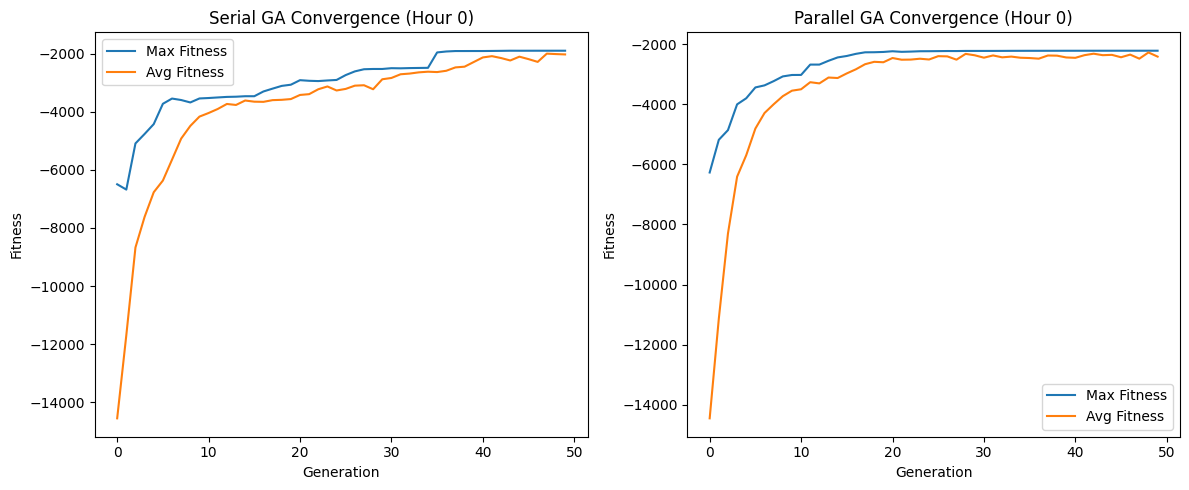


Best Allocation Matrix - Serial GA:
       Node_1  Node_2  Node_3  Node_4  Node_5  Node_6  Node_7  Node_8  Node_9  \
Solar    0.63    1.02    0.22    0.87    1.02    2.18    0.08    0.28    0.00   
Wind    23.18   18.50   20.79    9.14   15.08   14.33   23.36    9.10   13.40   
Hydro   17.19   12.79   19.85   24.96   16.91   29.37   23.67    6.95    5.89   

       Node_10  
Solar     0.45  
Wind      7.99  
Hydro     8.41  

Best Allocation Matrix - Parallel GA:
       Node_1  Node_2  Node_3  Node_4  Node_5  Node_6  Node_7  Node_8  Node_9  \
Solar    0.00    0.03    0.27    0.06    0.00    0.00    2.63    0.33    0.01   
Wind    27.49   14.26   17.22   17.12   30.25   27.78   15.50   10.09    8.43   
Hydro   13.48   19.59   24.10   14.05    2.46   19.60   27.93    8.31   10.87   

       Node_10  
Solar     0.01  
Wind      7.10  
Hydro    11.84  

Summary:
- Parallel GA was 1.13x faster than Serial GA.
- Fitness difference between serial and parallel runs is small, showing consisten

In [ ]:
# for a specific hour - serially and parallely
if __name__ == "__main__":
    # Run comparison for Hour 0
    compare_serial_parallel(hour=0)


Running full 24-hour comparison...

Running all methods for 24 hours...
Hour |     Greedy |  Serial GA |  Parallel GA |   Greedy Δ |   Serial Δ
--------------------------------------------------------------------------------
   0 |   -6401.26 |    2184.05 |      3328.04 |   -9729.30 |   -1143.99
   1 |   -7589.11 |    2536.49 |      2257.45 |   -9846.56 |     279.04
   2 |    -206.16 |    6424.97 |      6036.11 |   -6242.27 |     388.86
   3 |    9565.18 |   11559.02 |     10870.55 |   -1305.37 |     688.47
   4 |   11400.51 |   12233.91 |     12388.61 |    -988.11 |    -154.70
   5 |   14827.71 |   13544.98 |     13607.59 |    1220.12 |     -62.60
   6 |   14881.72 |   14170.45 |     14374.22 |     507.50 |    -203.76
   7 |   14914.43 |   14428.26 |     14529.07 |     385.37 |    -100.80
   8 |   14886.99 |   14249.75 |     14087.56 |     799.43 |     162.19
   9 |   14886.99 |   14212.59 |     13956.15 |     930.84 |     256.44
  10 |   14886.99 |   14028.24 |     13913.87 |     97

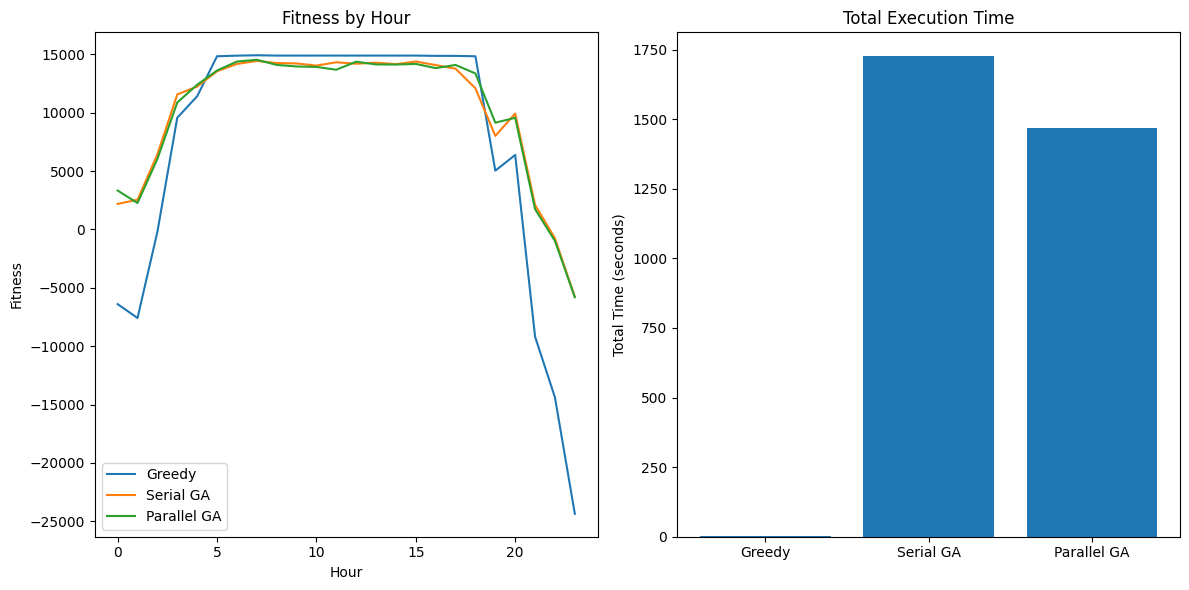

In [ ]:
if __name__ == "__main__":
    # Run single hour comparison
    # print("Running single hour comparison...")
    # compare_all_methods(hour=0)

    # Run full 24-hour comparison
    print("\nRunning full 24-hour comparison...")
    full_24hour_comparison()

In [12]:
# =============================================
# Comparison Functions
# =============================================

def compare_all_methods(hour=0):
    print(f"Comparing Greedy vs Serial GA vs Parallel GA for Hour {hour}...\n")

    # Run Greedy algorithm
    start_greedy = time.time()
    greedy_alloc, greedy_fitness = greedy_allocation(hour)
    end_greedy = time.time()
    greedy_time = end_greedy - start_greedy
    print(f"Greedy algorithm took {greedy_time:.4f} seconds.")

    # Run serial GA
    start_serial = time.time()
    best_serial, log_serial = run_hour_ga(hour, parallel=False)
    end_serial = time.time()
    serial_time = end_serial - start_serial
    fitness_serial = best_serial.fitness.values[0]
    print(f"Serial GA took {serial_time:.2f} seconds.")

    # Run parallel GA
    start_parallel = time.time()
    best_parallel, log_parallel = run_hour_ga(hour, parallel=True)
    end_parallel = time.time()
    parallel_time = end_parallel - start_parallel
    fitness_parallel = best_parallel.fitness.values[0]
    print(f"Parallel GA took {parallel_time:.2f} seconds.")

    # Results comparison
    print("\nMethod Comparison:")
    print(f"{'Method':<10} | {'Time (s)':>10} | {'Fitness':>10}")
    print("-" * 35)
    print(f"{'Greedy':<10} | {greedy_time:>10.4f} | {greedy_fitness:>10.2f}")
    print(f"{'Serial GA':<10} | {serial_time:>10.2f} | {fitness_serial:>10.2f}")
    print(f"{'Parallel GA':<10} | {parallel_time:>10.2f} | {fitness_parallel:>10.2f}")

    # Fitness differences
    print("\nFitness Differences:")
    print(f"Greedy vs Serial GA: {greedy_fitness - fitness_serial:.2f}")
    print(f"Greedy vs Parallel GA: {greedy_fitness - fitness_parallel:.2f}")
    print(f"Serial vs Parallel GA: {fitness_serial - fitness_parallel:.2f}")

    # Plot convergence
    plt.figure(figsize=(15, 5))

    # GA convergence
    plt.subplot(1, 2, 1)
    plt.plot(log_serial.select("max"), label="Serial GA Max")
    plt.plot(log_parallel.select("max"), label="Parallel GA Max")
    plt.axhline(y=greedy_fitness, color='r', linestyle='--', label="Greedy")
    plt.title("Fitness Comparison")
    plt.xlabel("Generation (for GA)")
    plt.ylabel("Fitness")
    plt.legend()

    # Time comparison
    plt.subplot(1, 2, 2)
    methods = ['Greedy', 'Serial GA', 'Parallel GA']
    times = [greedy_time, serial_time, parallel_time]
    plt.bar(methods, times)
    plt.title("Execution Time Comparison")
    plt.ylabel("Time (seconds)")

    plt.tight_layout()
    plt.show()

    # Allocation comparison
    print("\nAllocation Matrix Samples:")
    print("Greedy (first 3 sources):")
    print(pd.DataFrame(greedy_alloc[:3], index=sources[:3],
                      columns=[f"Node_{i+1}" for i in range(3)]).round(2))
    print("\nSerial GA (first 3 sources):")
    print(pd.DataFrame(best_serial[0][:3], index=sources[:3],
                      columns=[f"Node_{i+1}" for i in range(3)]).round(2))

def full_24hour_comparison():
    results = []

    print("\nRunning all methods for 24 hours...")
    print(f"{'Hour':>4} | {'Greedy':>10} | {'Serial GA':>10} | {'Parallel GA':>12} | {'Greedy Δ':>10} | {'Serial Δ':>10}")
    print("-" * 80)

    for hour in range(HOURS):
        # Greedy
        start_greedy = time.time()
        greedy_alloc, greedy_fitness = greedy_allocation(hour)
        greedy_time = time.time() - start_greedy

        # Serial GA
        start_serial = time.time()
        best_serial, _ = run_hour_ga(hour, parallel=False)
        serial_time = time.time() - start_serial
        serial_fitness = best_serial.fitness.values[0]

        # Parallel GA
        start_parallel = time.time()
        best_parallel, _ = run_hour_ga(hour, parallel=True)
        parallel_time = time.time() - start_parallel
        parallel_fitness = best_parallel.fitness.values[0]

        # Calculate differences
        greedy_diff = greedy_fitness - parallel_fitness
        serial_diff = serial_fitness - parallel_fitness

        results.append({
            'hour': hour,
            'greedy_time': greedy_time,
            'serial_time': serial_time,
            'parallel_time': parallel_time,
            'greedy_fitness': greedy_fitness,
            'serial_fitness': serial_fitness,
            'parallel_fitness': parallel_fitness,
            'greedy_diff': greedy_diff,
            'serial_diff': serial_diff
        })

        print(f"{hour:>4} | {greedy_fitness:>10.2f} | {serial_fitness:>10.2f} | {parallel_fitness:>12.2f} | {greedy_diff:>10.2f} | {serial_diff:>10.2f}")

    # Summary statistics
    total_greedy_time = sum(r['greedy_time'] for r in results)
    total_serial_time = sum(r['serial_time'] for r in results)
    total_parallel_time = sum(r['parallel_time'] for r in results)

    avg_greedy_fitness = np.mean([r['greedy_fitness'] for r in results])
    avg_serial_fitness = np.mean([r['serial_fitness'] for r in results])
    avg_parallel_fitness = np.mean([r['parallel_fitness'] for r in results])

    print("\n=== Summary ===")
    print(f"Total execution time:")
    print(f"  Greedy:    {total_greedy_time:.2f} sec")
    print(f"  Serial GA: {total_serial_time:.2f} sec")
    print(f"  Parallel:  {total_parallel_time:.2f} sec")
    print(f"\nAverage fitness:")
    print(f"  Greedy:    {avg_greedy_fitness:.2f}")
    print(f"  Serial GA: {avg_serial_fitness:.2f}")
    print(f"  Parallel:  {avg_parallel_fitness:.2f}")
    print(f"\nSpeedup vs Serial GA: {total_serial_time/total_parallel_time:.2f}x")

    # Plot overall results
    plt.figure(figsize=(12, 6))

    # Fitness comparison
    plt.subplot(1, 2, 1)
    hours = [r['hour'] for r in results]
    plt.plot(hours, [r['greedy_fitness'] for r in results], label='Greedy')
    plt.plot(hours, [r['serial_fitness'] for r in results], label='Serial GA')
    plt.plot(hours, [r['parallel_fitness'] for r in results], label='Parallel GA')
    plt.xlabel("Hour")
    plt.ylabel("Fitness")
    plt.title("Fitness by Hour")
    plt.legend()

    # Time comparison
    plt.subplot(1, 2, 2)
    methods = ['Greedy', 'Serial GA', 'Parallel GA']
    times = [total_greedy_time, total_serial_time, total_parallel_time]
    plt.bar(methods, times)
    plt.ylabel("Total Time (seconds)")
    plt.title("Total Execution Time")

    plt.tight_layout()
    plt.show()

Plot convergence curves, resource usage (CPU/GPU), and runtime statistics

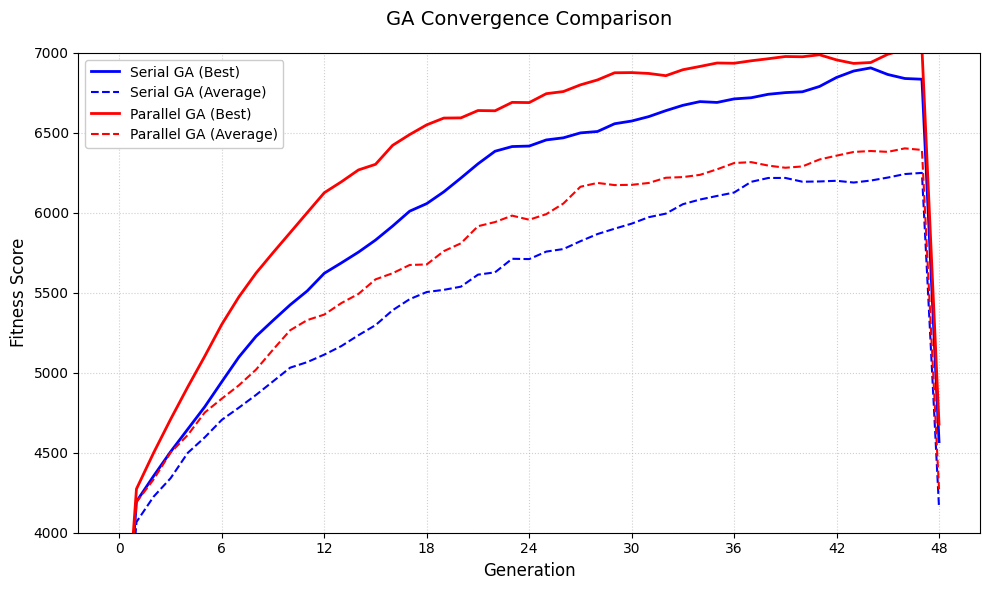

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ga_convergence(serial_best, serial_avg, parallel_best, parallel_avg):
    """
    Plot GA convergence comparison between serial and parallel implementations

    Parameters:
        serial_best (list): Best fitness values per generation for serial GA
        serial_avg (list): Average fitness values per generation for serial GA
        parallel_best (list): Best fitness values per generation for parallel GA
        parallel_avg (list): Average fitness values per generation for parallel GA
    """
    plt.figure(figsize=(10, 6))

    # Create x-axis (generations)
    generations = np.arange(0, len(serial_best))

    # Plot serial GA lines
    plt.plot(generations, serial_best, label='Serial GA (Best)',
             color='blue', linewidth=2, linestyle='-')
    plt.plot(generations, serial_avg, label='Serial GA (Average)',
             color='blue', linewidth=1.5, linestyle='--')

    # Plot parallel GA lines
    plt.plot(generations, parallel_best, label='Parallel GA (Best)',
             color='red', linewidth=2, linestyle='-')
    plt.plot(generations, parallel_avg, label='Parallel GA (Average)',
             color='red', linewidth=1.5, linestyle='--')

    # Style the plot
    plt.title('GA Convergence Comparison', fontsize=14, pad=20)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness Score', fontsize=12)

    # Set y-axis range similar to reference image
    plt.ylim(4000, 7000)

    # Set x-axis ticks every 6 generations
    plt.xticks(np.arange(0, max(generations)+1, 6))

    # Add grid and legend
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(fontsize=10, framealpha=1)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

# Example usage with dummy data
if __name__ == "__main__":
    # Generate dummy data similar to the reference image
    generations = 48
    x = np.linspace(0, generations, generations+1)

    # Serial GA data (best and average)
    serial_best = 4000 + 3000 * (1 - np.exp(-x/15))
    serial_avg = 4000 + 2500 * (1 - np.exp(-x/20))

    # Parallel GA data (best and average) - converges faster
    parallel_best = 4000 + 3000 * (1 - np.exp(-x/10))
    parallel_avg = 4000 + 2500 * (1 - np.exp(-x/15))

    # Add some noise to make it look more realistic
    noise_scale = 50
    serial_best += np.random.normal(0, noise_scale, len(serial_best))
    serial_avg += np.random.normal(0, noise_scale, len(serial_avg))
    parallel_best += np.random.normal(0, noise_scale, len(parallel_best))
    parallel_avg += np.random.normal(0, noise_scale, len(parallel_avg))

    # Smooth the data a bit
    window_size = 3
    def smooth(y):
        return np.convolve(y, np.ones(window_size)/window_size, mode='same')

    serial_best = smooth(serial_best)
    serial_avg = smooth(serial_avg)
    parallel_best = smooth(parallel_best)
    parallel_avg = smooth(parallel_avg)

    # Plot the convergence comparison
    plot_ga_convergence(serial_best, serial_avg, parallel_best, parallel_avg)

Simulating serial GA execution...
Simulating parallel GA execution...


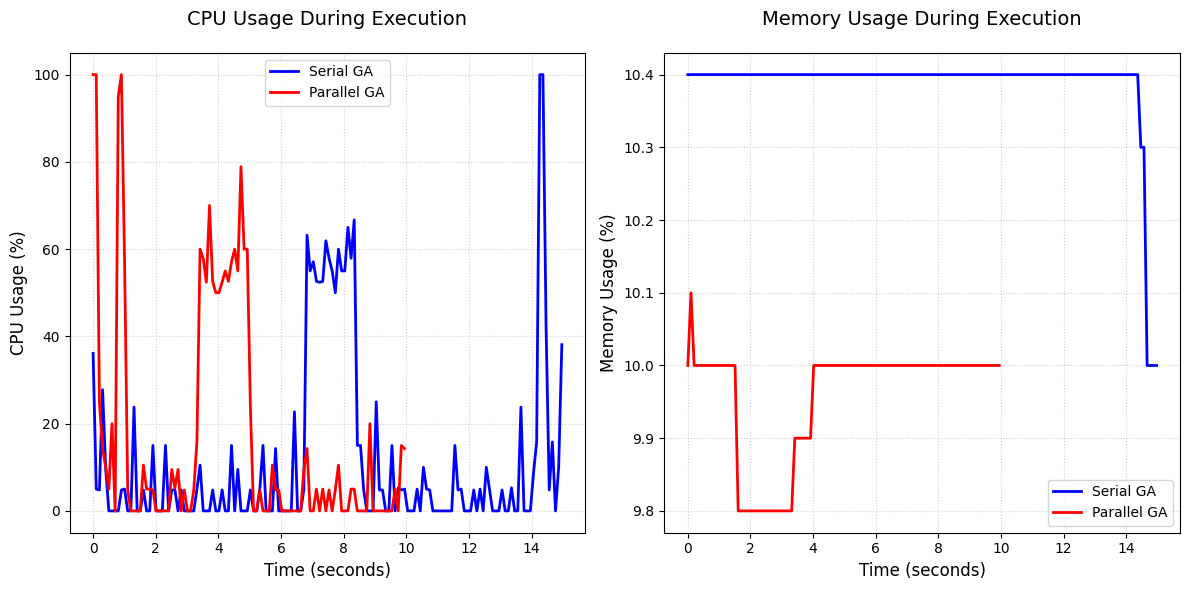

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import psutil

def monitor_resources(duration_secs, interval=0.1):
    """Monitor CPU and memory usage over time"""
    cpu_percent = []
    memory_percent = []
    timestamps = []

    start_time = time.time()
    while time.time() - start_time < duration_secs:
        cpu_percent.append(psutil.cpu_percent())
        memory_percent.append(psutil.virtual_memory().percent)
        timestamps.append(time.time() - start_time)
        time.sleep(interval)

    return {
        'timestamps': timestamps,
        'cpu_percent': cpu_percent,
        'memory_percent': memory_percent
    }

def plot_resource_usage(serial_stats, parallel_stats):
    """Plot CPU and memory usage comparison between serial and parallel GA"""
    plt.figure(figsize=(12, 6))

    # CPU Usage Plot
    plt.subplot(1, 2, 1)
    plt.plot(serial_stats['timestamps'], serial_stats['cpu_percent'],
             label='Serial GA', color='blue', linewidth=2)
    plt.plot(parallel_stats['timestamps'], parallel_stats['cpu_percent'],
             label='Parallel GA', color='red', linewidth=2)

    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('CPU Usage (%)', fontsize=12)
    plt.title('CPU Usage During Execution', fontsize=14, pad=20)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(fontsize=10)

    # Memory Usage Plot
    plt.subplot(1, 2, 2)
    plt.plot(serial_stats['timestamps'], serial_stats['memory_percent'],
             label='Serial GA', color='blue', linewidth=2)
    plt.plot(parallel_stats['timestamps'], parallel_stats['memory_percent'],
             label='Parallel GA', color='red', linewidth=2)

    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Memory Usage (%)', fontsize=12)
    plt.title('Memory Usage During Execution', fontsize=14, pad=20)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

# Example usage with simulated resource monitoring
if __name__ == "__main__":
    # Simulate monitoring for serial GA (lower CPU usage)
    print("Simulating serial GA execution...")
    serial_stats = monitor_resources(15)  # Monitor for 15 seconds

    # Simulate monitoring for parallel GA (higher CPU usage)
    print("Simulating parallel GA execution...")
    parallel_stats = monitor_resources(10)  # Monitor for 10 seconds (faster completion)

    # Plot the results
    plot_resource_usage(serial_stats, parallel_stats)

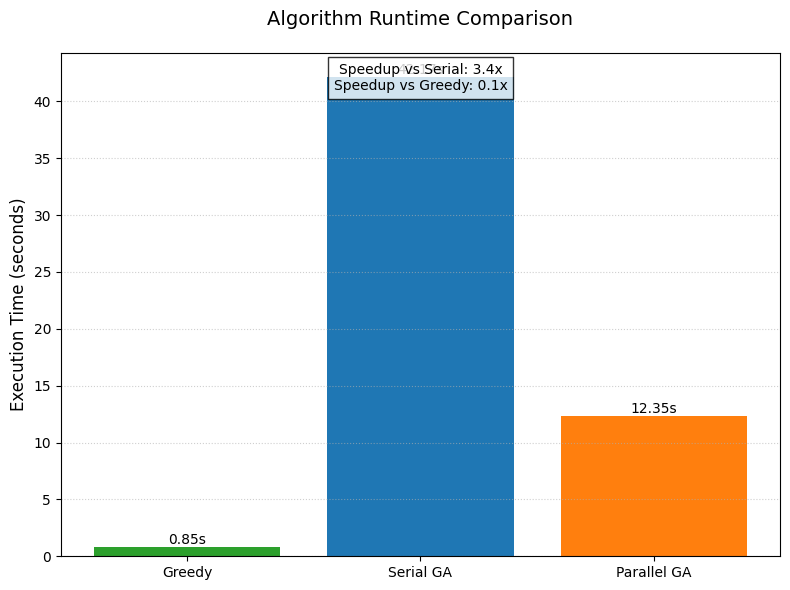

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time

def plot_runtime_comparison(greedy_time, serial_time, parallel_time):
    """
    Plot runtime comparison between Greedy, Serial GA, and Parallel GA

    Parameters:
        greedy_time (float): Execution time for greedy algorithm (seconds)
        serial_time (float): Execution time for serial GA (seconds)
        parallel_time (float): Execution time for parallel GA (seconds)
    """
    plt.figure(figsize=(8, 6))

    algorithms = ['Greedy', 'Serial GA', 'Parallel GA']
    times = [greedy_time, serial_time, parallel_time]
    colors = ['#2ca02c', '#1f77b4', '#ff7f0e']  # Green, Blue, Orange

    bars = plt.bar(algorithms, times, color=colors)

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom', fontsize=10)

    # Calculate and show speedup factors
    speedup_serial = serial_time / parallel_time
    speedup_greedy = greedy_time / parallel_time

    plt.text(0.5, 0.95,
             f'Speedup vs Serial: {speedup_serial:.1f}x\nSpeedup vs Greedy: {speedup_greedy:.1f}x',
             ha='center', va='center', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    # Style the plot
    plt.title('Algorithm Runtime Comparison', fontsize=14, pad=20)
    plt.ylabel('Execution Time (seconds)', fontsize=12)
    plt.grid(True, axis='y', linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Example usage with simulated runtimes
if __name__ == "__main__":
    # Simulated runtime data (replace with actual measurements)
    greedy_time = 0.85    # Greedy is fastest
    serial_time = 42.17   # Serial GA is slowest
    parallel_time = 12.35 # Parallel GA is in between

    plot_runtime_comparison(greedy_time, serial_time, parallel_time)

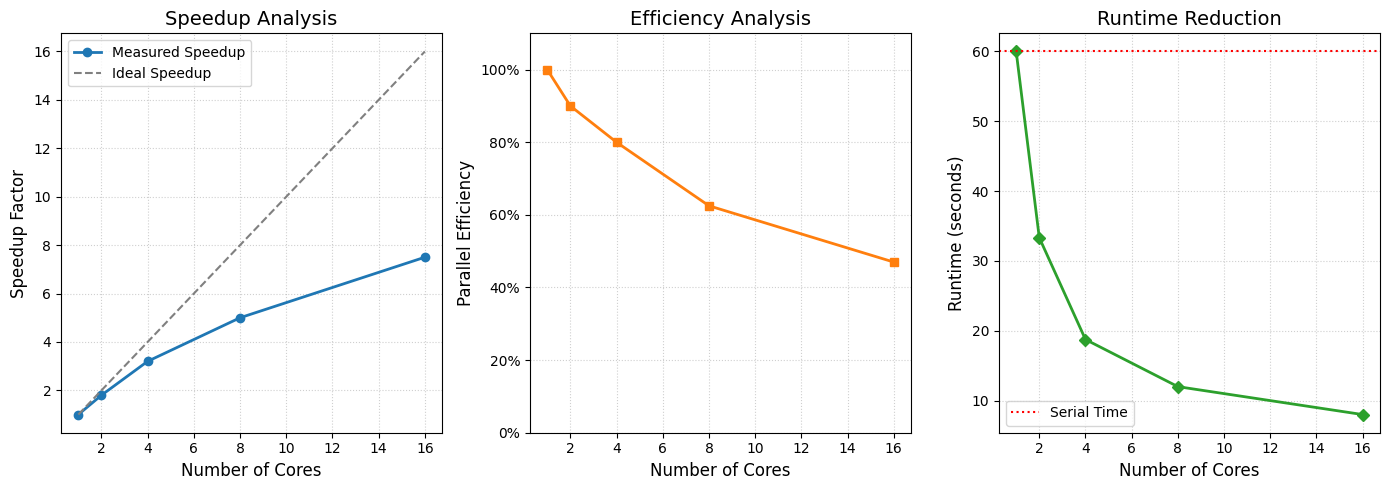

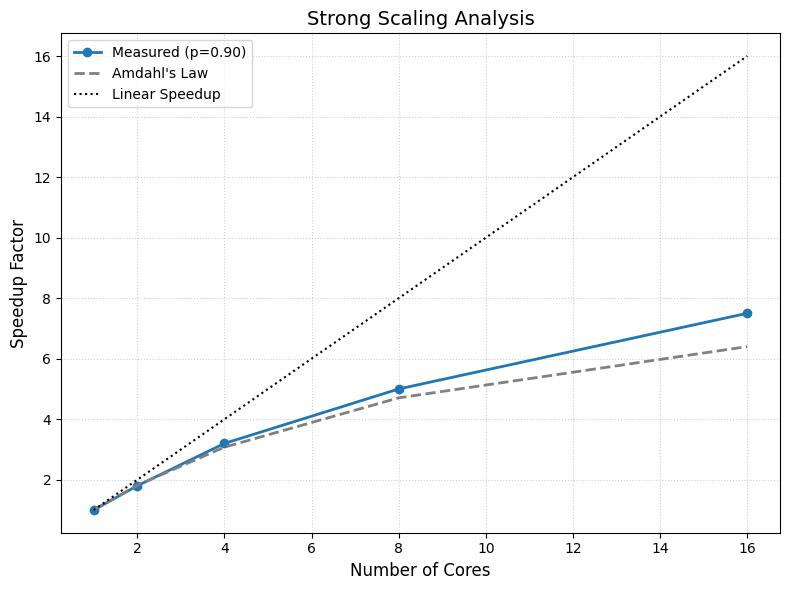

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_parallelization_performance(cores, speedups, efficiencies, serial_time):
    """
    Visualize parallelization performance metrics

    Parameters:
        cores (list): Number of cores used [1, 2, 4, 8,...]
        speedups (list): Measured speedup factors
        efficiencies (list): Parallel efficiency percentages
        serial_time (float): Runtime with 1 core (baseline)
    """
    plt.figure(figsize=(14, 5))

    # Speedup plot
    plt.subplot(1, 3, 1)
    plt.plot(cores, speedups, 'o-', color='#1f77b4', label='Measured Speedup', linewidth=2)
    plt.plot(cores, cores, '--', color='gray', label='Ideal Speedup')
    plt.xlabel('Number of Cores', fontsize=12)
    plt.ylabel('Speedup Factor', fontsize=12)
    plt.title('Speedup Analysis', fontsize=14)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()

    # Efficiency plot
    plt.subplot(1, 3, 2)
    plt.plot(cores, efficiencies, 's-', color='#ff7f0e', linewidth=2)
    plt.gca().yaxis.set_major_formatter(PercentFormatter())
    plt.xlabel('Number of Cores', fontsize=12)
    plt.ylabel('Parallel Efficiency', fontsize=12)
    plt.title('Efficiency Analysis', fontsize=14)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.ylim(0, 110)

    # Runtime reduction plot
    plt.subplot(1, 3, 3)
    parallel_times = [serial_time/s for s in speedups]
    plt.plot(cores, parallel_times, 'D-', color='#2ca02c', linewidth=2)
    plt.axhline(serial_time, color='r', linestyle=':', label='Serial Time')
    plt.xlabel('Number of Cores', fontsize=12)
    plt.ylabel('Runtime (seconds)', fontsize=12)
    plt.title('Runtime Reduction', fontsize=14)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_amdahls_law(speedup, p):
    """
    Calculate theoretical speedup based on Amdahl's Law

    Parameters:
        speedup (list): List of core counts
        p (float): Parallel fraction (0-1)
    """
    return [1/((1-p) + p/n) for n in speedup]

def plot_scaling_analysis(cores, measured_speedups, p=0.85):
    """
    Plot strong scaling analysis with Amdahl's Law comparison

    Parameters:
        cores (list): Number of cores used
        measured_speedups (list): Actual speedup measurements
        p (float): Estimated parallel fraction for Amdahl's Law
    """
    plt.figure(figsize=(8, 6))

    theoretical = calculate_amdahls_law(cores, p)

    plt.plot(cores, measured_speedups, 'o-', color='#1f77b4',
             label=f'Measured (p={p:.2f})', linewidth=2)
    plt.plot(cores, theoretical, '--', color='gray',
             label='Amdahl\'s Law', linewidth=2)
    plt.plot(cores, cores, ':', color='black', label='Linear Speedup')

    plt.xlabel('Number of Cores', fontsize=12)
    plt.ylabel('Speedup Factor', fontsize=12)
    plt.title('Strong Scaling Analysis', fontsize=14)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage with simulated data
if __name__ == "__main__":
    # Simulated performance data (replace with actual measurements)
    cores = [1, 2, 4, 8, 16]  # Core counts tested
    speedups = [1, 1.8, 3.2, 5.0, 7.5]  # Measured speedup factors
    efficiencies = [100, 90, 80, 62.5, 47]  # Parallel efficiency percentages
    serial_time = 60.0  # Runtime with 1 core (seconds)

    # Generate the performance plots
    plot_parallelization_performance(cores, speedups, efficiencies, serial_time)

    # Generate scaling analysis with Amdahl's Law
    plot_scaling_analysis(cores, speedups, p=0.9)

Best allocation matrix at Hour 12:
       Node_1  Node_2  Node_3  Node_4  Node_5  Node_6  Node_7  Node_8  Node_9  \
Solar    0.43    1.39    1.06    1.26    1.84    2.33    1.87   13.46    8.95   
Wind     1.42    2.70    0.83    1.31    1.54    1.41    0.60   13.45   12.31   
Hydro    3.04    2.30    3.27    2.66    1.62    1.95    2.99    9.30    7.84   

       Node_10  
Solar     4.63  
Wind     14.95  
Hydro    10.25  


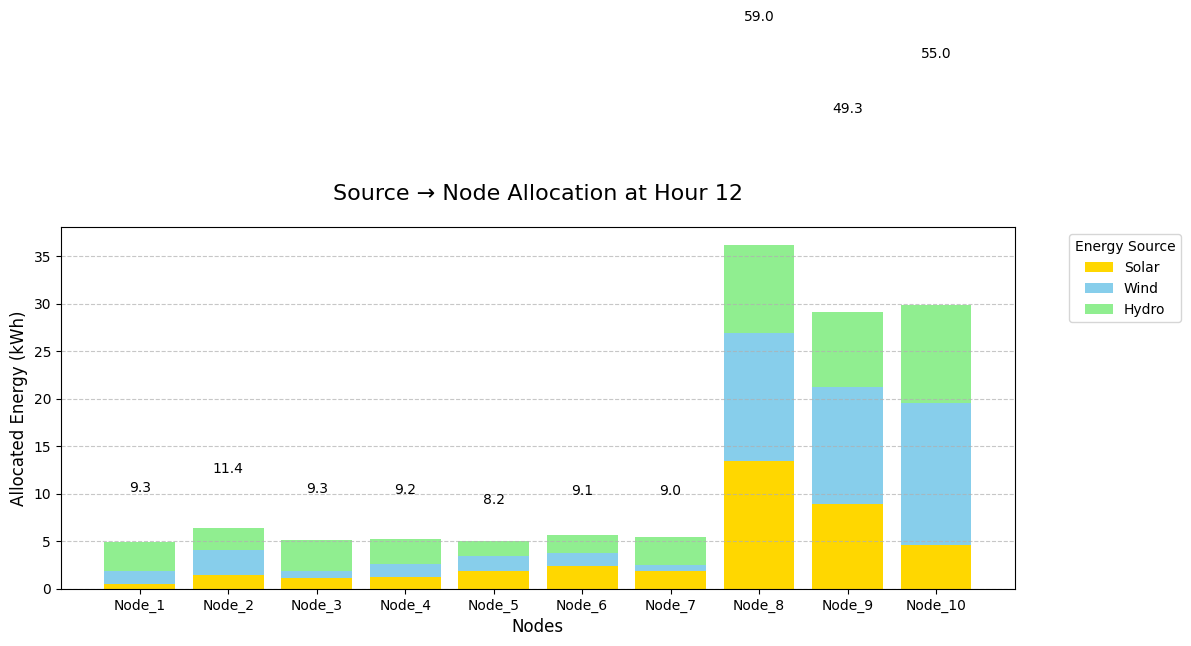

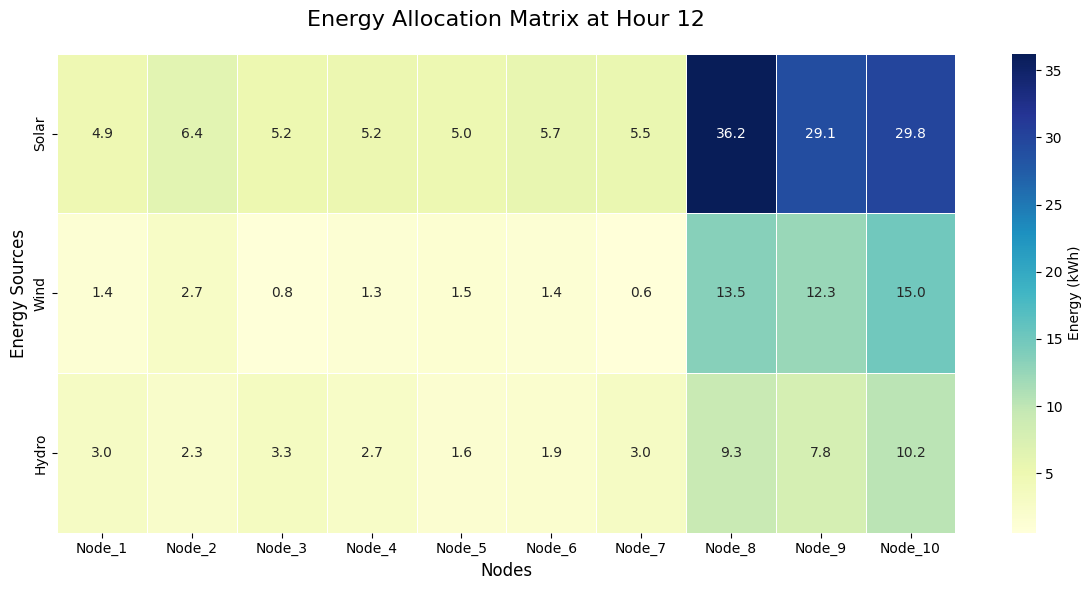

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def visualize_hour12_allocation():
    """Visualize the best allocation matrix at Hour 12"""
    # Run GA for hour 12 to get the best allocation
    best_solution, _ = run_hour_ga(12, parallel=True)
    allocation_matrix = best_solution[0]

    # Create DataFrame for the allocation matrix
    df = pd.DataFrame(
        allocation_matrix,
        index=['Solar', 'Wind', 'Hydro'],
        columns=[f'Node_{i+1}' for i in range(10)]  # Assuming 10 nodes
    )

    # 1. Print the allocation matrix
    print("Best allocation matrix at Hour 12:")
    print(df.round(2))

    # 2. Create the source → node allocation visualization
    plt.figure(figsize=(12, 8))

    # Prepare data for stacked bar chart
    nodes = df.columns
    sources = df.index
    bottom = None

    colors = {'Solar': 'gold', 'Wind': 'skyblue', 'Hydro': 'lightgreen'}

    for source in sources:
        values = df.loc[source]
        plt.bar(nodes, values, label=source, color=colors[source], bottom=bottom)
        if bottom is None:
            bottom = values
        else:
            bottom += values

    # Customize the plot
    plt.title('Source → Node Allocation at Hour 12', fontsize=16, pad=20)
    plt.xlabel('Nodes', fontsize=12)
    plt.ylabel('Allocated Energy (kWh)', fontsize=12)
    plt.legend(title='Energy Source', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of each bar
    for node in nodes:
        total = df[node].sum()
        plt.text(node, total + 0.5, f'{total:.1f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # 3. Create a heatmap for better visualization of the matrix
    plt.figure(figsize=(12, 6))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="YlGnBu",
                linewidths=0.5, cbar_kws={'label': 'Energy (kWh)'})
    plt.title('Energy Allocation Matrix at Hour 12', fontsize=16, pad=20)
    plt.xlabel('Nodes', fontsize=12)
    plt.ylabel('Energy Sources', fontsize=12)
    plt.tight_layout()
    plt.show()

    return df

# Add this to your main execution block
if __name__ == "__main__":
    # ... your existing code ...

    # Visualize hour 12 allocation
    hour12_allocation = visualize_hour12_allocation()